**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [1]:
NAME = "Madison Chester"

---

In [2]:
## import libraries needed
## make sure you run this code first!

library(testthat)
library(digest)
library(stringr)

## Question 1.

In class, we saw an example of kNN (k-Nearest Neighbors) model used for predicting concentration of nitrogen oxides (NOx) in Boston air, based on a single predictor - weighted average distance from 5 employment centers in Boston area. In this question you are going to tune the hyperparameter $k$, i.e. find its optimal value, and then fit the model with that value of $k$. But first, you will produce the following plot from class, which shows how performance of the fitted model varies with the change of the tuning parameter $k$.

<img src="hw2-pic1.png" style="width: 600px;"/>


We will use simple validation and split the data into `train` and `test` subsets.

To simplify, we first extract the two variables `nox` and `dist` from `Boston` data frame from `MASS` library, and create a new data frame called `df`. To do that, run the following cell.

In [3]:
## RUN THIS CELL

library(MASS)
library(kknn)

n = nrow(Boston)  #number of observatons/rows, i.e. sample size

xall = Boston$dis  #our input variable
yall = 10*Boston$nox  #our output variable

# create data frame df that consists only of our input and output variables
df = data.frame(xall,yall) #simple data frame for convenience

dim(df) #checking the dimension of the dataframe df (note there are 506 obs)

[1] 506   2

### Part (a)


Use the seed 123 in the function `set.seed()` to make sure you are going to produce the same (pseudo)random sample as in the test cells. Then, create the vector `tr` which is a random sample of 400 indices from the index set: 1,2,3,...,506 (i.e. all rows in `df`). This will be the set of indices for our *training* data (hence the name `tr`). 

To create `tr`, use `sample()` function. So, your command should look like  

`tr = sample(x=??, size=??, replace=FALSE)`

You can check out the documentation for the function `sample()`; in fact, `replace=FALSE` is the default, so even if you don't include it, you will take a sample of 400 values without replacement (i.e. no index value will appear more than once).

If you set the seed to 123 before creating `tr`, first couple of values of `tr` should be

`415, 463, 179, 14, 195`

<br>

In [4]:
set.seed(123)
vec <- seq(1, 506, 1)
tr = sample(x = vec, size = 400, replace = FALSE)

In [5]:
## check whether first 5 values of vector tr are 415, 463, 179, 14, 195

if (test_that(desc="", code={
    expect_equal(tr[1:5], c(415, 463, 179, 14, 195))
    }) != TRUE) stop("Sorry, wrong answer")


## check whether tr is of length 400

if (test_that(desc="", code={
    expect_equal(length(tr), 400)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎊
Test passed 🎉


In [6]:
## check whether tr is correct (hidden tests)



### Part (b)

Create data frames `train` and `test` from the data frame `df`. The data frame `train` should consist of observations (i.e. rows) of `df` whose indices are precisely those 400 random indices from vector `tr`. The data frame `test` should consist of the complement of `tr` (you can use `df[-tr, ]` for taking the complementary indices, i.e. precisely those indices which are not in `tr`).

**Hint:** First two rows of `train` should be

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **xall** &nbsp; &nbsp; &nbsp; **yall** <br>
**415** `1.6582  6.93` 

**463** `2.7344  7.13
`

and of `test`:

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; **xall** &nbsp; &nbsp; &nbsp; **yall** <br>
**1** `4.0900  5.38` 

**6** `6.0622  4.58`

In [7]:
train <- df[tr,]
test <- df[-tr,]

In [8]:

## check whether train and test are data frames and of right format

if (test_that(desc="", code={
    expect_equal(is.data.frame(train), TRUE)
    expect_equal(dim(train),c(400,2))
    }) != TRUE) stop("Sorry, train is not correct")

if (test_that(desc="", code={
    expect_equal(is.data.frame(test), TRUE)
    expect_equal(dim(test),c(506-400,2))
    }) != TRUE) stop("Sorry, test is not correct")


Test passed 🌈
Test passed 😸


In [9]:
## check whether the first two rows of train and test data are correct


if (test_that(desc="", code={
    expect_equal(norm(as.matrix(train[1:2,]) 
                      - matrix(c(1.6582, 6.93, 2.7344, 7.13),nrow=2,byrow=T), type="2") < 1.e-4,
                TRUE)
    }) != TRUE) stop("Sorry, train is not correct")

if (test_that(desc="", code={
    expect_equal(norm(as.matrix(test[1:2,]) 
                      - matrix(c(4.0900, 5.38, 6.0622, 4.58),nrow=2,byrow=T), type="2") < 1.e-4,
                TRUE)
    }) != TRUE) stop("Sorry, test is not correct")


Test passed 😸
Test passed 😸


In [10]:
## check whether train and test data are correct (hidden tests)




We now create vector `kvec` of possible values for the tuning parameter (i.e. hyperparameter) $k$ in the kNN model. We will take values 1,2,...,350. We could also include values up to the size of the training sample `train` (which is 400), but it's not difficult to see that the performance of the model for such values of $k$ would be lower than performance for all other values of $k$.

Apart from `kvec`, we also define `nk` to be the length of `kvec` (i.e. 350). Run the following cell to create `kvec` and `nk`.

In [11]:
## run this code to create kvec and define nk

#loop over values of k, fit on train, predict on test
kvec = 1:350
nk=length(kvec)


### Part (c)

In this part you should create vectors `outRMSE` and `inRMSE`. For each $k\in$ `kvec`, we fit the model using training data `train`. Then, we compute the out-of-sample root mean squared error $outRMSE_k$ as well as in-sample root mean squared error $inRMSE_k$:

$$outRMSE_k = \sqrt{{1\over n}\sum_{i\,\notin \,tr} (\hat{y}_i - y_i)^2}$$

$$inRMSE_k = \sqrt{{1\over n}\sum_{i\,\in \,tr} (\hat{y}_i - y_i)^2}$$

Note that the sum in $outRMSE_k$ goes over all indices that are NOT in the training index set `tr` while in $inRMSE_k$ the some goes precisely over those indices which ARE in the training index set `tr`.

<br>

To compute $outRMSE$ and $inRMSE$ we will need to find the fitted values $\hat{y}_i$'s, for $i\notin $`tr` and  
 
For this purpose, we use function `kknn()` from the library `kknn` (imported above). We can use a code line of the form 

`kmod = kknn(yall ~ xall, train=??, test=??, k=??, kernel="rectangular")`

where `yall ~ xall` is the R formula regressing the output `yall` on the input `xall`. The argument `train` is an appropriate data frame used for training/fitting, with columns named  `xall` and `yall`, so that `kknn()` knows which variables to take from the training data frame `train` and use for what (output or input). Among other info, the created object `kmod` also stores the fitted values applied on the data from the data frame `test`. Set the argument `test` to be a data frame that contains not just `xall`, but also the corresponding `yall` values from your sample. 

For example, if we want to fit kNN model with $k=123$ on our training data `train` and compute fitted values on our test data `test`, we would use

`kmod = kknn(yall ~ xall, train=train, test=test, k=123, kernel="rectangular")` and then 

`kmod$fitted` would be the vector of desireable fitted values.

Also, if we want to fit kNN model with $k=123$ on our training data `train` and compute fitted values on the same (i.e. training) data, then we can create R object `kmodtr` as

`kmodtr = kknn(yall ~ xall, train=train, test=train, k=123, kernel="rectangular")` and then 

`kmodtr$fitted` would be the vector of desireable fitted values.

<br>

Your task is to do this for each $k\in$ `kvec` (not just $k=123$). Create a for-loop that for each $k \in$ `kvec` = $(1,2,...,\texttt{nk})$ computes $outRMSE_k$ and $inRMSE_k$ as given above and stores these values as $k$-th components of the R vectors `outRMSE` and `inRMSE`, respectively.

You can start first by pre-allocating memory for `outRMSE` and `inRMSE`:

`outRMSE = rep(0,nk)` <br>
`inRMSE = rep(0,nk)`

(this just creates 0-vectors, both of length `nk`, whose compononents you would then need to change to appropriate values; memory pre-allocation was briefly discussed in DAT301).

The computation in your for-loop may take a couple of moments, since you are fitting a lot of models (i.e. for each $k$).

If everything is okay, first couple of values of the two vectors are:

outRMSE = `0.776118930538112, 0.720259336484056, 0.688533442062602, 0.688563663027939, 0.713899101268837...`

<br>

inRMSE = `0.0294448637286709, 0.413066386916195, 0.479819913844999, 0.515748405687066, 0.532981421345998...`



In [12]:
outRMSE = rep(0,nk) #pre-allocating RMSE for out-of-sample data
inRMSE = rep(0,nk) #pre-allocating RMSE for in-sample data

for (k in kvec) {
    kmod = kknn(yall ~ xall, train=train, test=test, k=k, kernel="rectangular")
    outRMSE[k] = sqrt(mean((kmod$fitted-test$yall)^2))
}

for (k in kvec) { 
    kmodtr = kknn(yall ~ xall, train=train, test=train, k=k, kernel="rectangular")
    inRMSE[k] = sqrt(mean((kmodtr$fitted-train$yall)^2))
}

In [13]:
## check whether outRMSE and inRMSE are numeric vectors of length nk=350

if (test_that(desc="", code={
    expect_equal(is.numeric(outRMSE),TRUE)
    expect_equal(length(outRMSE)==350, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")

if (test_that(desc="", code={
    expect_equal(is.numeric(inRMSE),TRUE)
    expect_equal(length(inRMSE)==350, TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🎉
Test passed 🎊


In [14]:
## check whether first couple of values of outRMSE are correct

if (test_that(desc="", code={
    expect_equal(norm(outRMSE[1:5]-c(0.776118930538112, 
                                0.720259336484056, 
                                0.688533442062602, 
                                0.688563663027939, 
                                0.713899101268837),type="2") < 1.e-5,TRUE)
    }) != TRUE) stop("Sorry, wrong answer")



Test passed 🌈


In [15]:
## check whether first couple of values of inRMSE are correct

if (test_that(desc="", code={
    expect_equal(norm(inRMSE[1:5]-c(0.0294448637286709, 
                                     0.413066386916195, 
                                     0.479819913844999, 
                                     0.515748405687066, 
                                     0.532981421345998),type="2") < 1.e-5,TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 🌈


<br>

If everything is okay, by running th following cell you should get the plot as above. Try to understand all parts of this code.

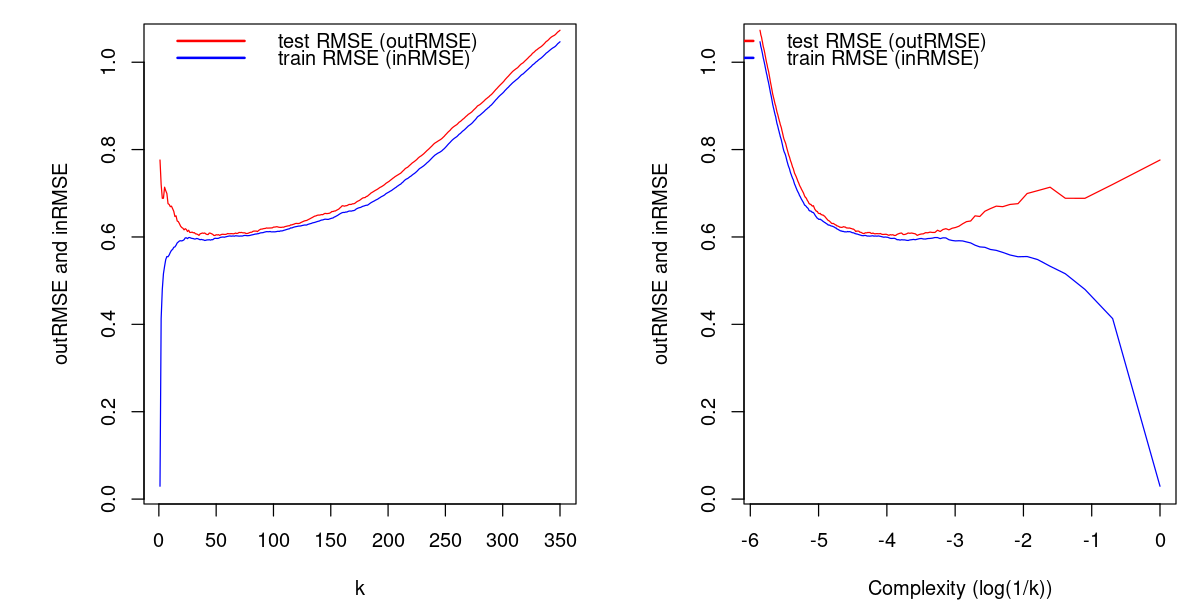

In [16]:
## run this cell

# Change plot size 
options(repr.plot.width=10, repr.plot.height=5)

#make plot consist of two subplots in a row
par(mfrow=c(1,2),mar=c(4,6,1,1))

plot(kvec,outRMSE,type="l",
     xlab="k",ylab="outRMSE and inRMSE",
     col="red",ylim=range(inRMSE))
lines(kvec,inRMSE,col="blue")
legend(x = "topleft",          # Position
       legend = c("test RMSE (outRMSE)", "train RMSE (inRMSE)"),  # Legend texts
       lty = c(1, 1),           # Line types
       col = c("red", "blue"),           # Line colors
       lwd = 2,                 # Line width
       bty = "n")   # boundary type

plot(log(1/kvec),outRMSE,type="l",
     xlab="Complexity (log(1/k))",ylab="outRMSE and inRMSE",
     col="red",ylim=range(inRMSE))
lines(log(1/kvec),inRMSE,col="blue")
legend(x = "topright",          # Position
       legend = c("test RMSE (outRMSE)", "train RMSE (inRMSE)"),  # Legend texts
       lty = c(1, 1),           # Line types
       col = c("red", "blue"),           # Line colors
       lwd = 2,                 # Line width
       bty = "n")   # boundary type




### Part (d)

Find $k$ for which the out-of-sample root mean squared error is the smallest. You can use `which.min(outRMSE)` to find the index of the smallest value in the vector `outRMSE`.

Create variable `kbest` that stores the value $k$ for which `outRMSE` has the smallest value.

**Hint:** `kbest` should be between 40 and 50.

In [17]:
kbest = kvec[which.min(outRMSE)]
kbest 

[1] 48

In [18]:
## check whether kbest is between 40 and 50

if (test_that(desc="", code={
    expect_equal((40 <= kbest) & (kbest <= 50),TRUE)
    }) != TRUE) stop("Sorry, wrong answer")


Test passed 😸


In [19]:
## check whether kbest is correct (hidden tests)


You can now plot all the data and include your fitted model (with your `kbest` value of the tuning parameter $k$). Run the following code. If your `kbest` is correct (or at least reasonable), the red curve that represents your model should fit relatively nicely.

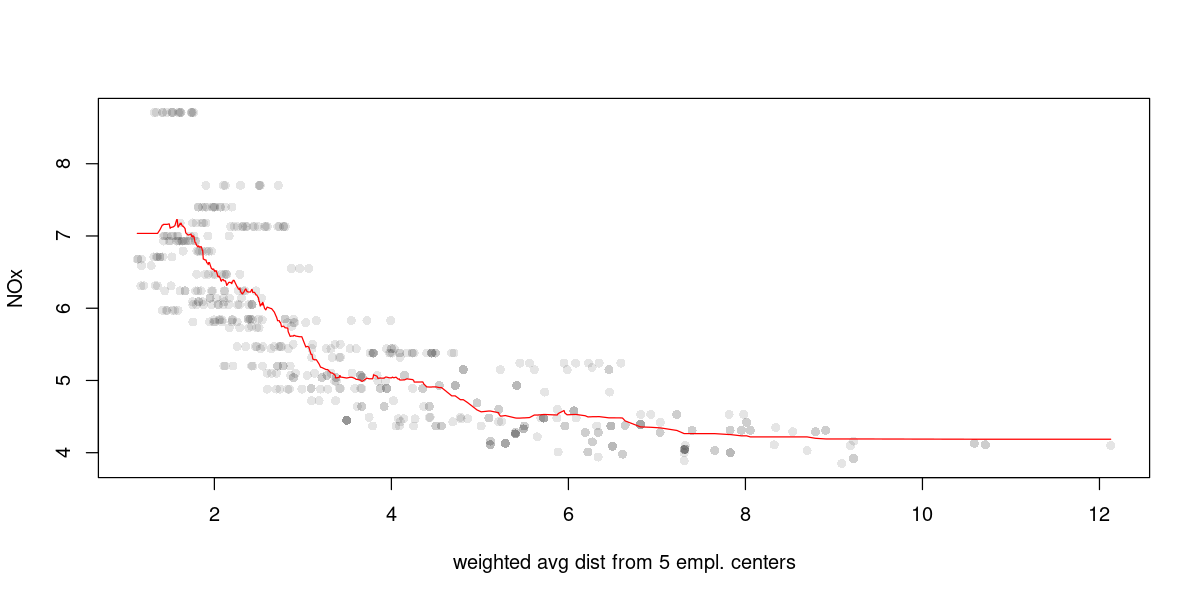

In [20]:
##run the following code

sortedxall = data.frame(xall=sort(df$xall)) #sort xall and put them in data frame
kmodbest = kknn(yall~xall, df, test=sortedxall, k=kbest,kernel="rectangular")
plot(df,pch=16,col=rgb(0,0,0,0.1), xlab="weighted avg dist from 5 empl. centers", ylab="NOx")
lines(sortedxall$xall, kmodbest$fitted, col="red")

<font style="font-size: 14pt;"><strong>IMPORTANT: In this problem, we fine-tuned the hyperparameter $k$. However, if we choose another training subsample even of the same sample size as above (for example, different seed), the result would be somewhat different (hopefully `kbest` wouldn't differ a lot). You should be aware of this randomness and the fact that `kbest` is not some absolutely optimal value of $k$.</strong></font>

<br>

## Question 2.


In order to include all the observations as training data at some point, and as test data at other time, we do cross-validation.

It is important to understand the idea of cross-validation from class and how it is implemented in a code. 

Make sure you understand the following code.

In [21]:
#defining loss functions mse and rmse
mse = function(yout,yhat){mean((yout-yhat)^2)}
rmse = function(yout,yhat){sqrt(mean((yout-yhat)^2))}

#create fcn knnCV that does cross validation for given number of folds (nfolds)
knnCV = function(xall, yall, lossfun=rmse, nfolds=10, kvec){
   
    df = data.frame(xall, yall)
    n = nrow(df)

    ##shuffle data 
    idx = sample(1:n, size=n, replace=F) #shuffle indices
    df = df[idx,] #shuffle data

    fdsize = n %/% nfolds  #fold size (n = fdsize*nfolds + remdr)
    remdr = n %% nfolds   #remainder in the euclidean division algorithm

    loss = rep(0,length(kvec))  

    for (j in 1:length(kvec)){

       loss_folds = rep(0,nfolds)
   
       for (i in 1:nfolds){
          ## n = fdsize*nfolds + remdr
          idxout = ((i-1)*fdsize+1):(i*fdsize)
          ##to each of the 1st remdr folds, we add 
          ##one of the last remdr observations/rows
          if (i <= remdr) {idxout = c(idxout, nfolds*fdsize+i)
          }
          test = df[idxout,]
          train = df[-idxout,]
   
          kmod = kknn::kknn(yall~., train=train, test=test,
                        k=kvec[j],kernel="rectangular")
          loss_folds[i] = lossfun(test$yall,kmod$fitted)
      
       }#end of looping over folds
   
       loss[j] = mean(loss_folds)
   
    }#end of looping over kvec

 return(loss)

}#end of function knnCV

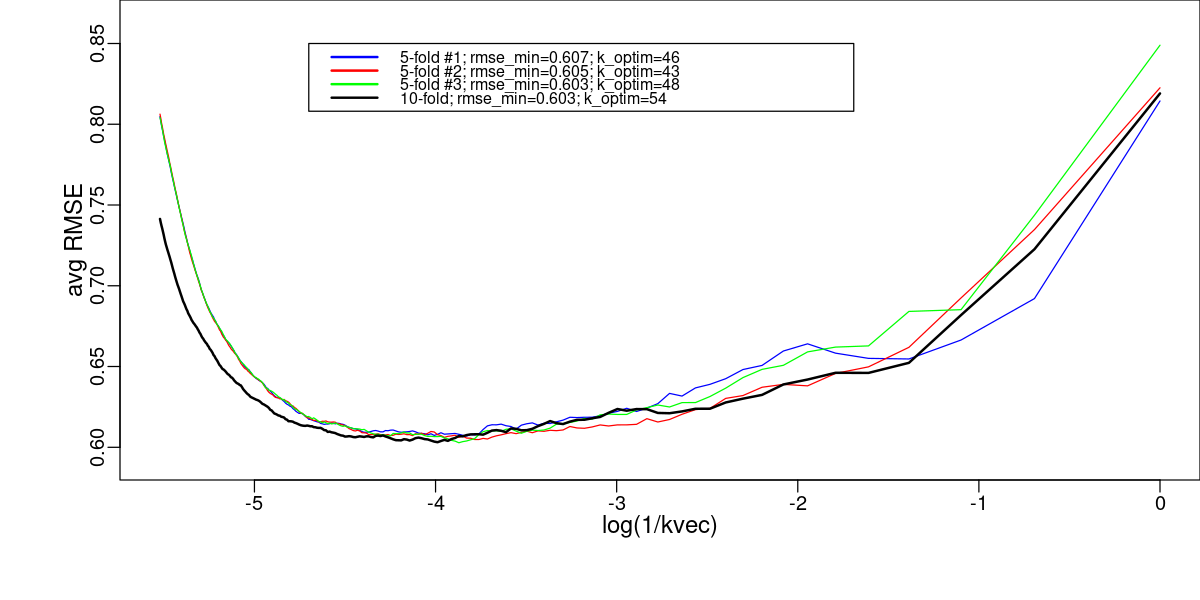

In [22]:
## running function knnCV with nfolds=5 three times, and once with nfolds=10

kvec = 1:250
nfolds = 5

set.seed(123)

err5_1 = knnCV(xall=Boston$dis, yall=10*Boston$nox,nfolds=5, kvec=kvec)
err5_2 = knnCV(xall=Boston$dis, yall=10*Boston$nox,nfolds=5, kvec=kvec)
err5_3 = knnCV(xall=Boston$dis, yall=10*Boston$nox,nfolds=5, kvec=kvec)
err10 = knnCV(xall=Boston$dis, yall=10*Boston$nox,nfolds=10, kvec=kvec)

legendvec = c(paste0("5-fold #1; rmse_min=",as.character(round(min(err5_1),3)),"; k_optim=",as.character(kvec[which.min(err5_1)])),
              paste0("5-fold #2; rmse_min=",as.character(round(min(err5_2),3)),"; k_optim=",as.character(kvec[which.min(err5_2)])),
              paste0("5-fold #3; rmse_min=",as.character(round(min(err5_3),3)),"; k_optim=",as.character(kvec[which.min(err5_3)])),
              paste0("10-fold; rmse_min=",as.character(round(min(err10),3)),"; k_optim=",as.character(kvec[which.min(err10)])))



#png(filename="cv-kfold-5-10.png", width=700, height=450)

#par(mai=c(0.4,0.35,0.15,0.1))
par(mar=c(5,5,0,0),mgp=c(1.4,0.45,0),cex.lab=1.2)

rnge = range(c(err5_1,err5_2,err5_3,err10))
ylm = c(0.98*rnge[1],1.02*rnge[2])

plot(x=log(1/kvec),y=err5_1,ylim=ylm,
     ylab="avg RMSE",type="l",col="blue")
lines(x=log(1/kvec),y=err5_2,col="red")
lines(x=log(1/kvec),y=err5_3,col="green")
lines(x=log(1/kvec),y=err10,col="black",lwd=2)
legend(-4.7,0.85,legend=legendvec,
       col=c("blue","red","green","black"),lwd=2,cex=0.8)


### Part (a)

Did you understand the code? Create a character variable `ans` with one of the possible values: "yes" or "no". 

So, if you understood the code, your answer should be 

`ans = "yes"`

and if you didn't, your answer should be 

`ans = "no"`

In [23]:
ans = "yes"

In [24]:
## check whether ans is either equal to "yes" or "no"

if (test_that(desc="", code={
    expect_equal(ans %in% c("yes","no"),TRUE)
    }) != TRUE) stop("Sorry, something is wrong with the variable ans.")



Test passed 🥳


In [25]:
## check whether ans is equal to "yes" (if not, make sure you trully understand the code!!!)

if (test_that(desc="", code={
    expect_equal(ans == "yes",TRUE)
    }) != TRUE) stop("Sorry, you must make sure you understand how cross-validation works!")


Test passed 🥇
